# Test Age and Gender Models on a Custom Image
This notebook loads your trained models and predicts age and gender for an image in the `test` folder.

In [7]:
# Imports and setup
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# Model and image config
IMG_SIZE = (128, 128)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_DIR = '../models'
TEST_IMG_DIR = '../test'

# List test images
test_images = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg','.png','.jpeg'))]
print('Test images:', test_images)

Test images: ['18d036_5fc4122ccef44bad8c938830cf1b1394~mv2.jpg', '321-5eddde6a0ac1a-a.jpg', 'ab67616100005174d110d2ed2b1063abdf5777db.jpg', 'images.jpg']


In [8]:
# Define model class (must match training definition)
class BaseCNN(nn.Module):
    def __init__(self, output_units=1, task='age'):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*(IMG_SIZE[0]//8)*(IMG_SIZE[1]//8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_units)
        )
        self.task = task

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        if self.task=='gender':
            x = torch.sigmoid(x)
        return x

In [9]:
# Load models
age_model = BaseCNN(output_units=1, task='age')
gender_model = BaseCNN(output_units=1, task='gender')

age_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'age_model.pth'), map_location=DEVICE))
gender_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'gender_model.pth'), map_location=DEVICE))

age_model.eval(); age_model.to(DEVICE)
gender_model.eval(); gender_model.to(DEVICE)

BaseCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropou

In [10]:
# Define transforms (should match validation/test transforms used in training)
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Gender label mapping (edit if needed)
gender_map = {0: 'Female', 1: 'Male'}

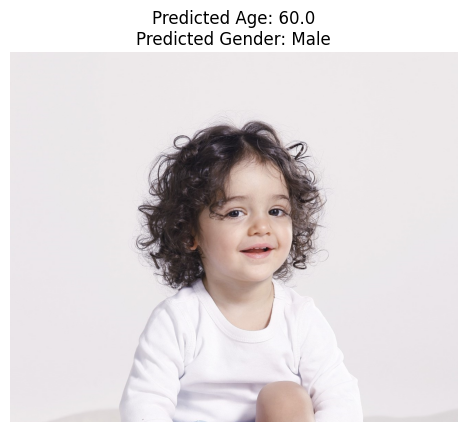

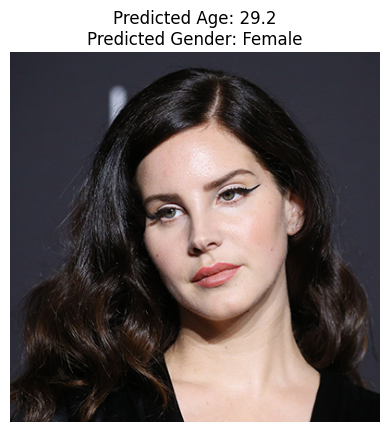

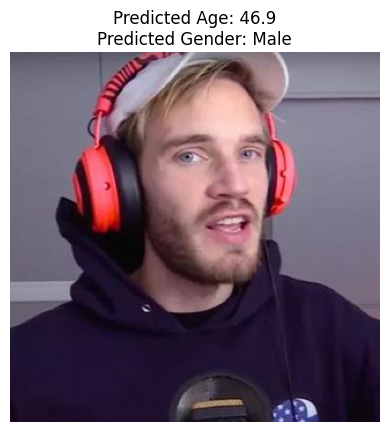

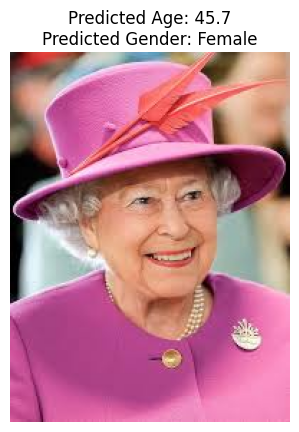

In [11]:
# Predict on all test images
for fname in test_images:
    img_path = os.path.join(TEST_IMG_DIR, fname)
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(DEVICE)  # shape (1,3,H,W)

    # Age prediction
    with torch.no_grad():
        age_pred = age_model(img_tensor).item()

    # Gender prediction
    with torch.no_grad():
        gender_pred = gender_model(img_tensor).item()
        gender_label = gender_map[int(round(gender_pred))]

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Age: {age_pred:.1f}\nPredicted Gender: {gender_label}')
    plt.show()